# The Battle of Neighbourhoods 

## 1. Introduction 
In this project, we will implement a machine learning solution to cluster neighborhoods in Toronto and London to identify the neighborhoods that are the best option for immigrants based on nearby important facilities such as schools, hospitals, and shops etc... 

For this project, we will use two datasets: the first toronto.csv dataset consists of Toronto boroughs, neighbourhoods and their corresponding postcodes. The second london.csv dataset consists of boroughs, neighbourhoods and their corresponding postcodes in London. Both datasets have been scrapped from the Wikipedia page.

Foursquare API offers access to a vast datasets of location data and location information, including address, photos, tips, ratings and comments. This project will use the Foursquare API and Geopy data to identify nearby locations within 500 meters of each neighborhood in Toronto and London.

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from pandas.io.json import json_normalize
import matplotlib.cm as cm 
import matplotlib.colors as colors
import requests 
#!pip install folium
import folium # map rendering library
#!pip install geopy
#!pip install geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!pip install sklearn    
from sklearn.cluster import KMeans

<br> 
## 2. Data 

### 2.1 Data Collection 
Toronto and London neighbourhoods data was scraped from Wikipedia page and converted into pandas dataframe. <br>
London Wiki: https://en.wikipedia.org/wiki/List_of_areas_of_London <br>
Toronoto Wiki: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M <br>
A csv file that has the geographical coordinates of each postal code for neighbourhoods in Toronto is provided. <br>
All the files can be found in the github page: https:https://github.com/UnLeaSh-iB/Coursera-Capstone <br>

### 2.2 Data Cleaning

<font size="4">**Toronto**</font><br>
Let's load Toronto dataframe and clean up the data.

In [2]:
toronto = pd.read_csv('toronto.csv')
toronto.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


Ignore cells with a borough that is Not assigned.

In [3]:
indexNames = toronto[ toronto['Borough'] =='Not assigned'].index
toronto.drop(indexNames , inplace=True)
toronto.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,Malvern / Rouge
11,M3B,North York,Don Mills
12,M4B,East York,Parkview Hill / Woodbine Gardens
13,M5B,Downtown Toronto,Garden District


If a cell has a borough but a Not assigned Neighbourhood, then the Neighbourhood will be the same as the borough.

In [4]:
toronto.loc[toronto['Neighbourhood'] =='Not assigned' , 'Neighbourhood'] = toronto['Borough']
toronto.head()

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [16]:
toronto.shape

(103, 3)

In [17]:
df_to_geo_duplicate = toronto.pivot_table(index=['PostalCode'], aggfunc='size')
df_to_geo_duplicate

PostalCode
M1B    1
M1C    1
M1E    1
M1G    1
M1H    1
M1J    1
M1K    1
M1L    1
M1M    1
M1N    1
M1P    1
M1R    1
M1S    1
M1T    1
M1V    1
M1W    1
M1X    1
M2H    1
M2J    1
M2K    1
M2L    1
M2M    1
M2N    1
M2P    1
M2R    1
M3A    1
M3B    1
M3C    1
M3H    1
M3J    1
M3K    1
M3L    1
M3M    1
M3N    1
M4A    1
M4B    1
M4C    1
M4E    1
M4G    1
M4H    1
M4J    1
M4K    1
M4L    1
M4M    1
M4N    1
M4P    1
M4R    1
M4S    1
M4T    1
M4V    1
M4W    1
M4X    1
M4Y    1
M5A    1
M5B    1
M5C    1
M5E    1
M5G    1
M5H    1
M5J    1
M5K    1
M5L    1
M5M    1
M5N    1
M5P    1
M5R    1
M5S    1
M5T    1
M5V    1
M5W    1
M5X    1
M6A    1
M6B    1
M6C    1
M6E    1
M6G    1
M6H    1
M6J    1
M6K    1
M6L    1
M6M    1
M6N    1
M6P    1
M6R    1
M6S    1
M7A    1
M7R    1
M7Y    1
M8V    1
M8W    1
M8X    1
M8Y    1
M8Z    1
M9A    1
M9B    1
M9C    1
M9L    1
M9M    1
M9N    1
M9P    1
M9R    1
M9V    1
M9W    1
dtype: int64

<font size="4">**London**</font><br>

Now, Let's load London dataset.

In [12]:
london = pd.read_csv('London.csv')
london.head()

,Neighbourhood,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [13]:
london.shape

(381, 3)

In [14]:
london = london.sort_values(by='Postcode', ascending=False).reset_index(drop=True)
london

,Neighbourhood,Borough,Postcode
0,Covent Garden,Westminster,WC2
1,Charing Cross,Westminster,WC2
2,Aldwych,Westminster,WC2
3,St Giles,Camden,WC2
4,Bloomsbury,Camden,WC1
5,Holborn,Camden,WC1
6,St Pancras,Camden,WC1
7,King's Cross,Camden and Islington,WC1
8,Maida Vale,Westminster,W9
9,Little Venice,Westminster,W9


In [18]:
london = london.groupby(['Postcode'], sort=False).agg( ' / '.join)
london = london.reset_index()
london

,Postcode,Borough,Neighbourhood
0,WC2,Westminster / Camden,Covent Garden / Charing Cross / Aldwych / St G...
1,WC1,Camden / Camden and Islington,Bloomsbury / Holborn / St Pancras / King's Cross
2,W9,Westminster,Maida Vale / Little Venice
3,W8,Kensington and Chelsea,Holland Park
4,W7,Ealing,Hanwell
5,W6,Hammersmith and Fulham,Hammersmith
6,W5,Ealing,Ealing
7,W4,"Hounslow / Hounslow, Ealing, Hammersmith and F...",Gunnersbury / Grove Park / Chiswick / Bedford ...
8,W3,"Ealing, Hammersmith and Fulham",Acton
9,W2,Westminster,Bayswater / Paddington


In [20]:
df_ln_geo_duplicate = london.pivot_table(index=['Postcode'], aggfunc='size')
df_ln_geo_duplicate

Postcode
 DA14    1
 DA15    1
 DA16    1
 DA18    1
 DA7     1
 E13     1
 E15     1
 E16     1
 E18     1
 E8      1
 E9      1
 EN5     1
 HA7     1
 HA8     1
 IG11    1
 N1      1
 N10     1
 N12     1
 N14     1
 N15     1
 N16     1
 N17     1
 N18     1
 N19     1
 N22     1
 N3      1
 N8      1
 NW10    1
 NW3     1
 NW4     1
 NW6     1
 NW7     1
 NW8     1
 SE11    1
 SE12    1
 SE13    1
 SE17    1
 SE2     1
 SE20    1
 SE26    1
 SE27    1
 SE5     1
 SW10    1
 SW19    1
 SW20    1
 SW3     1
 SW5     1
 SW9     1
 W11     1
 W13     1
 W14     1
 W2      1
 W4      1
 WC2     1
BR3      1
DA5      1
DA6      1
E1       1
E10      1
E11      1
E12      1
E13      1
E14      1
E15      1
E16      1
E17      1
E18      1
E2       1
E3       1
E4       1
E5       1
E6       1
E7       1
E8       1
E9       1
EC1      1
EC3      1
EC4      1
EN5      1
HA3      1
IG8      1
N1       1
N10      1
N11      1
N12      1
N13      1
N14      1
N15      1
N16      1
N19      1
N

In [ ]:
london = london.drop_duplicates(subset =['Neighbourhood', 'Borough'])
#london = london.drop_duplicates(subset =['Neighbourhood'], keep='first')
london = london.reset_index(drop=True)
london.head()

In [21]:
london.shape

(175, 3)

Rows will the same postcode and borough will be combined into one row with the neighborhoods separated with a Slash.

In [ ]:
london = london.groupby(['Postcode','Borough'], sort=False).agg( '/ '.join)
london = london.reset_index()
london.head()

In [ ]:
london.shape

<br><br>
## 3. Methodology 

### 3.1 Obtain Coordinates 

<font size="4">**Toronto**</font><br>
Given that Geocoder package can be very unreliable, we will use a csv file that has the geographical coordinates of each postal code.

In [22]:
df_lon_lat = pd.read_csv('Geospatial_Coordinates.csv')
df_lon_lat.columns = ['PostalCode', 'Latitude', 'Longitude']
df_lon_lat.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge Toronto data and coordinates in one single dataframe.

In [23]:
df_toronto = pd.merge(toronto, df_lon_lat[['PostalCode','Latitude', 'Longitude']], on='PostalCode')
df_toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


Cheking duplicate coordinates

In [24]:
df_to_geo_duplicate = df_toronto.pivot_table(index=['Latitude', 'Longitude'], aggfunc='size')
df_to_geo_duplicate

Latitude   Longitude 
43.602414  -79.543484    1
43.605647  -79.501321    1
43.628841  -79.520999    1
43.628947  -79.394420    1
43.636258  -79.498509    1
43.636847  -79.428191    1
43.636966  -79.615819    1
43.640816  -79.381752    1
43.643515  -79.577201    1
43.644771  -79.373306    1
43.646435  -79.374846    1
43.647177  -79.381576    1
43.647927  -79.419750    1
43.648198  -79.379817    1
43.648429  -79.382280    1
43.648960  -79.456325    1
43.650571  -79.384568    1
43.650943  -79.554724    1
43.651494  -79.375418    1
43.651571  -79.484450    1
43.653206  -79.400049    1
43.653654  -79.506944    1
43.654260  -79.360636    1
43.657162  -79.378937    1
43.657952  -79.387383    1
43.659526  -79.340923    1
43.661608  -79.464763    1
43.662301  -79.389494    1
43.662696  -79.400049    1
43.662744  -79.321558    1
43.665860  -79.383160    1
43.667856  -79.532242    1
43.667967  -79.367675    1
43.668999  -79.315572    1
43.669005  -79.442259    1
43.669542  -79.422564    1
43.672

Now, let's replace the PostalCode column with city name.

In [25]:
df_toronto = df_toronto.drop(['PostalCode'], axis=1)
df_toronto.insert(0, 'City', 'Toronto')
df_toronto.head()

,City,Borough,Neighbourhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.753259,-79.329656
1,Toronto,North York,Victoria Village,43.725882,-79.315572
2,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,Toronto,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,Toronto,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


In [26]:
print('The Toronto dataframe has {} boroughs and {} Neighbourhoods.'.format(
        len(df_toronto['Borough'].unique()),
        df_toronto.shape[0]
    )
)

The Toronto dataframe has 10 boroughs and 103 Neighbourhoods.


<font size="4">**London**</font><br>
For London dataset, we did not find a file that has the geographical coordinates.

In [27]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{},London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

In [28]:
import geocoder
df_london = london
import time
start = time.time()
postal_codes = df_london['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  144.96322965621948 seconds


In [29]:
# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_ln_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_ln_coordinates

,Latitude,Longitude
0,51.516510,-0.119680
1,51.524500,-0.122730
2,51.525870,-0.195260
3,51.501620,-0.191730
4,51.508780,-0.336300
5,51.496170,-0.229350
6,51.514060,-0.300730
7,51.489440,-0.261940
8,51.513240,-0.267460
9,51.514940,-0.180480


In [30]:
df_london['Latitude'] = df_ln_coordinates['Latitude']
df_london['Longitude'] = df_ln_coordinates['Longitude']
df_london.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,WC2,Westminster / Camden,Covent Garden / Charing Cross / Aldwych / St G...,51.51651,-0.11968
1,WC1,Camden / Camden and Islington,Bloomsbury / Holborn / St Pancras / King's Cross,51.52450,-0.12273
2,W9,Westminster,Maida Vale / Little Venice,51.52587,-0.19526
3,W8,Kensington and Chelsea,Holland Park,51.50162,-0.19173
4,W7,Ealing,Hanwell,51.50878,-0.33630


In [31]:
df_ln_geo_duplicate = df_london.pivot_table(index=['Latitude', 'Longitude'], aggfunc='size')
df_ln_geo_duplicate

Latitude   Longitude
51.399250  -0.074140    1
51.410090  -0.056830    2
51.411170  -0.226230    2
51.415095  -0.035403    1
51.418700  -0.127530    1
51.419900  -0.088080    1
51.421700  -0.207960    2
51.426740  -0.055330    2
51.430370  -0.165580    1
51.434070  -0.103750    2
51.437220  -0.018680    1
51.441000  -0.088970    1
51.441220  -0.047640    1
51.444630   0.052120    1
51.447590   0.013500    2
51.448220  -0.148390    1
51.450660  -0.189970    1
51.452068   0.172230    1
51.452560  -0.070760    1
51.452950  -0.120830    1
51.455290  -0.099280    1
51.457550  -0.218450    1
51.459075   0.099121    1
51.460950  -0.139220    1
51.461960  -0.007540    2
51.462680  -0.035580    1
51.464820  -0.265910    1
51.467600  -0.162900    1
51.470010  -0.112490    1
51.470520   0.146706    1
51.471380   0.023380    1
51.472180  -0.067790    1
51.474570  -0.242120    1
51.474800  -0.093130    2
51.474890  -0.040380    1
51.476230  -0.130560    1
51.477720  -0.201450    1
51.481140  -0.024

In [ ]:
df_london = df_london.drop_duplicates(subset =['Latitude', 'Longitude'], keep='first')
df_london = df_london.reset_index(drop=True)
print(df_london.shape)
df_london

In [ ]:
df_ln_geo_duplicate = df_london.pivot_table(index=['Latitude', 'Longitude'], aggfunc='size')
df_ln_geo_duplicate

In [32]:
df_london = df_london.drop(['Postcode'], axis=1)
df_london.insert(0, 'City', 'London')
df_london.head()

,City,Borough,Neighbourhood,Latitude,Longitude
0,London,Westminster / Camden,Covent Garden / Charing Cross / Aldwych / St G...,51.51651,-0.11968
1,London,Camden / Camden and Islington,Bloomsbury / Holborn / St Pancras / King's Cross,51.52450,-0.12273
2,London,Westminster,Maida Vale / Little Venice,51.52587,-0.19526
3,London,Kensington and Chelsea,Holland Park,51.50162,-0.19173
4,London,Ealing,Hanwell,51.50878,-0.33630


In [33]:
print('The London dataframe has {} boroughs and {} Neighbourhoods.'.format(
        len(df_london['Borough'].unique()),
        df_london.shape[0]
    )
)

The London dataframe has 71 boroughs and 175 Neighbourhoods.


Let's Merge Toronto and London neighbourhoods into one dataframe first.

In [34]:
df_toronto_london =  pd.concat([df_toronto, df_london], sort=False)
print('There are total {} neighbourhoods in Toronto and London.'.format(df_toronto_london.shape[0]))
df_toronto_london.head()

There are total 278 neighbourhoods in Toronto and London.


,City,Borough,Neighbourhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.753259,-79.329656
1,Toronto,North York,Victoria Village,43.725882,-79.315572
2,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,Toronto,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,Toronto,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


In [35]:
# Let's save the Toronto and London neighbourhoods with coordiantes to csv files.
df_toronto.to_csv('toronto_with_coordinates.csv', sep='\t')
df_london.to_csv('london_with_coordinates.csv', sep='\t')

### <br>3.2 Data Visualization 

Visualize the data with Folium Maps. The neighbourhoods belong to the same borough will be plotted with the same color.

In [36]:
# Define a funciton that creates a map of different neighbourhoods in the city.
import geocoder
def getMap (cityname,countryname,dataframe):
    address = cityname + ',' + countryname

    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of ' + cityname + ' are {}, {}.'.format(latitude, longitude))
    
    # create map using latitude and longitude values.
    city_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Borough
    borough_name = dataframe['Borough'].unique().tolist()
    colnum = dataframe['Borough'].unique().size
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    for lat, lon, Neighbourhood, borough in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Neighbourhood'], dataframe['Borough']):
        cluster = borough_name.index(borough)
        label = '{}, {}'.format(Neighbourhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(city_map)  
    return city_map

<br><font size="4">**Toronto**</font> Neighbourhoods.

In [37]:
getMap('Toronto','Canada',df_toronto)

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


<br><font size="4">**London**</font> Neighbourhoods.

In [38]:
getMap('London','United Kingdom',df_london)

The geograpical coordinate of London are 51.5073219, -0.1276474.


### <br> 3.3  Use Foursquare API for Venues

Define Foursquare Credentials and Version.

In [39]:
CLIENT_ID = 'ERHZCVA5NNHKWGCDWBHZQB3KFSFE2YBD2RGMSJLLW54V1BGG' 
CLIENT_SECRET = '5FMWRF2BQEWTS1ETQC1SUOGNJBINRDEHWHE43NDBHR3OGHXL' 
VERSION = '20200425' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ERHZCVA5NNHKWGCDWBHZQB3KFSFE2YBD2RGMSJLLW54V1BGG
CLIENT_SECRET:5FMWRF2BQEWTS1ETQC1SUOGNJBINRDEHWHE43NDBHR3OGHXL


Create a function to get nearby venues of all the neighbourhoods in the city.

In [40]:
def getNearbyVenues(cities, boroughs, neighbourhoods, latitudes, longitudes, radius=500):
    
    # Define limit of venues to get
    LIMIT = 100
    
    venues_list=[]
    for city, borough, neighbourhood, lat, lng in zip(cities, boroughs, neighbourhoods, latitudes, longitudes):
        print(neighbourhood)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(city, 
            borough, 
            neighbourhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Borough',          
                  'Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue',  
                  'Venue Category']
    
    return(nearby_venues)

<br><font size="4">**Toronto**</font><br>

Call the getNearbyVenues function on each Neibourhood and create a new dataframe called toronto_venues.

In [42]:
toronto_venues = getNearbyVenues(df_toronto['City'], df_toronto['Borough'], 
                                 df_toronto['Neighbourhood'], df_toronto['Latitude'],
                                 df_toronto['Longitude']
                                )

Parkwoods
Victoria Village
Regent Park / Harbourfront
Lawrence Manor / Lawrence Heights
Queen's Park / Ontario Provincial Government
Islington Avenue
Malvern / Rouge
Don Mills
Parkview Hill / Woodbine Gardens
Garden District
Glencairn
West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale
Rouge Hill / Port Union / Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood
Guildwood / Morningside / West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor / Wilson Heights / Downsview North
Thorncliffe Park
Richmond / Adelaide / King
Dufferin / Dovercourt Village
Scarborough Village
Fairview / Henry Farm / Oriole
Northwood Park / York University
East Toronto
Harbourfront East / Union Station / Toronto Islands
Little Portugal / Trinity
Kennedy Park / Ionview / East Birchmount Park
Bayview Village
Downsview
T

Check the size of the dataframe.

In [43]:
print(toronto_venues.shape)
toronto_venues.head()

(2148, 7)


,City,Borough,Neighbourhood,Latitude,Longitude,Venue,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park
1,Toronto,North York,Parkwoods,43.753259,-79.329656,649 Variety,Convenience Store
2,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,Coffee Shop


Check how many venues were returned for each Neiborhood.

In [44]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.groupby('Neighbourhood').count()

There are 266 uniques categories.


,City,Borough,Latitude,Longitude,Venue,Venue Category
Neighbourhood,,,,,,
Agincourt,5,5,5,5,5,5
Alderwood / Long Branch,10,10,10,10,10,10
Bathurst Manor / Wilson Heights / Downsview North,18,18,18,18,18,18
Bayview Village,4,4,4,4,4,4
Bedford Park / Lawrence Manor East,24,24,24,24,24,24
Berczy Park,57,57,57,57,57,57
Birch Cliff / Cliffside West,4,4,4,4,4,4
Brockton / Parkdale Village / Exhibition Place,23,23,23,23,23,23
Business reply mail Processing CentrE,16,16,16,16,16,16


<font size="4">**London**</font><br>

Let's repeat the same process for London data.

In [50]:
london_venues = getNearbyVenues(df_london['City'], df_london['Borough'], 
                                 df_london['Neighbourhood'], df_london['Latitude'],
                                 df_london['Longitude']
                                )

Covent Garden / Charing Cross / Aldwych / St Giles
Bloomsbury / Holborn / St Pancras / King's Cross
Maida Vale / Little Venice
Holland Park
Hanwell
Hammersmith
Ealing
Gunnersbury / Grove Park / Chiswick / Bedford Park
Acton
Bayswater / Paddington
West Kensington
West Ealing
Shepherd's Bush / White City / Wormwood Scrubs
Notting Hill
North Kensington
Mayfair / Chinatown / Marylebone (also St Marylebone) / Soho / Fitzrovia
Oval / Stockwell / Vauxhall / Nine Elms
South Kensington / Kensington
Parsons Green / Fulham / Sands End
Earls Court
Clapham
Brompton / Chelsea
Raynes Park
Brixton
South Wimbledon / Colliers Wood / Wimbledon / Merton Park
Southfields / Earlsfield / Wandsworth
Tooting / Tooting Bec
Norbury / Streatham
Kingston Vale / Roehampton / Putney
Mortlake / East Sheen
Barnes / Castelnau
Balham
Battersea
West Brompton
Belgravia / Millbank / St James's / Pimlico / Knightsbridge / Westminster
New Eltham / Eltham / Middle Park / Well Hall / Mottingham / Falconwood / Longlands
Deptfor

Check the size of the dataframe.

In [51]:
print(london_venues.shape)
london_venues.head()

(5951, 7)


,City,Borough,Neighbourhood,Latitude,Longitude,Venue,Venue Category
0,London,Westminster / Camden,Covent Garden / Charing Cross / Aldwych / St G...,51.51651,-0.11968,Scarfes Bar,Hotel Bar
1,London,Westminster / Camden,Covent Garden / Charing Cross / Aldwych / St G...,51.51651,-0.11968,Rosewood London,Hotel
2,London,Westminster / Camden,Covent Garden / Charing Cross / Aldwych / St G...,51.51651,-0.11968,The Hoxton Holborn,Hotel
3,London,Westminster / Camden,Covent Garden / Charing Cross / Aldwych / St G...,51.51651,-0.11968,Sir John Soane's Museum,History Museum
4,London,Westminster / Camden,Covent Garden / Charing Cross / Aldwych / St G...,51.51651,-0.11968,Lincoln's Inn Fields,Park


Check how many venues were returned for each Neiborhood.

In [52]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))
london_venues.groupby('Neighbourhood').count()

There are 313 uniques categories.


,City,Borough,Latitude,Longitude,Venue,Venue Category
Neighbourhood,,,,,,
Acton,47,47,47,47,47,47
Anerley / Penge,6,6,6,6,6,6
Angel / Hackney,50,50,50,50,50,50
Archway / Upper Holloway,29,29,29,29,29,29
Arkley,24,24,24,24,24,24
Arnos Grove,24,24,24,24,24,24
Balham,36,36,36,36,36,36
Barnes / Castelnau,24,24,24,24,24,24
Barnet Gate,6,6,6,6,6,6


<br><font size="4">**Merge Toronto and London Venues into one dataframe.**</font><br>

In [53]:
toronto_ln_venues =  pd.concat([toronto_venues,london_venues])
print(toronto_ln_venues.shape)
toronto_ln_venues.head()

(8099, 7)


,City,Borough,Neighbourhood,Latitude,Longitude,Venue,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park
1,Toronto,North York,Parkwoods,43.753259,-79.329656,649 Variety,Convenience Store
2,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,Coffee Shop


We will change all types of restaurants such as 'French Restaurant', 'Pizza Place' and 'Sichuan Restaurant'into 'Restaurant'.

In [54]:
toronto_ln_venues.loc[toronto_ln_venues['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'
toronto_ln_venues.loc[toronto_ln_venues['Venue Category'].str.contains('Pizza Place', case=False), 'Venue Category'] = 'Restaurant'
print(toronto_ln_venues.shape)
toronto_ln_venues.head(10)


(8099, 7)


,City,Borough,Neighbourhood,Latitude,Longitude,Venue,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park
1,Toronto,North York,Parkwoods,43.753259,-79.329656,649 Variety,Convenience Store
2,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,Coffee Shop
5,Toronto,North York,Victoria Village,43.725882,-79.315572,Portugril,Restaurant
6,Toronto,North York,Victoria Village,43.725882,-79.315572,The Frig,Restaurant
7,Toronto,North York,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,Intersection
8,Toronto,North York,Victoria Village,43.725882,-79.315572,Pizza Nova,Restaurant
9,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,Roselle Desserts,Bakery


Peform one-hot encoding.

In [55]:
toronto_ln_onehot = pd.get_dummies(toronto_ln_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
toronto_ln_onehot['Neighbourhood'] = toronto_ln_venues['Neighbourhood'] 

# move Neighbourhood column to the first column
fixed_columns = [toronto_ln_onehot.columns[-1]] + list(toronto_ln_onehot.columns[:-1])
print(toronto_ln_onehot.shape)
toronto_ln_onehot.head()

(8099, 303)


,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Camera Store,Canal,Candy Store,Cemetery,Champagne Bar,Cheese Shop,Child Care Service,Chocolate Shop,Church,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Quad,College Rec Center,College Residence Hall,College Stadium,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Curling Ice,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Distribution Center,Dog Run,Donut Shop,Drugstore,Electronics Store,Entertainment Service,Event Space,Exhibit,Fabric Shop,Farmers Market,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Lake,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Men's Store,Metro Station,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Plane,Platform,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Radio Station,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Road,Roller Rink,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stables,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Strip Club,Student Center,Supermarket,Supplement Shop,Swim School,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Theater,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,University,Vape Store,Video Game Store,Video Store,Warehouse Store,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Now we need to clean the colums. For example, 'Art Gallery' and 'Art Museum' are basically in the same category.

In [56]:
def clean_columns(columns,newcolumnname,dataframe):
    value = 0
    for column in columns:
        value = dataframe[column] + value
    
    dataframe = dataframe.drop(columns,axis = 1)
    dataframe[newcolumnname] = value
    
    return dataframe

columns = ['Airport', 'Airport Food Court', 'Airport Gate', 'Airport Lounge', 'Airport Service', 'Airport Terminal']
newcolumnname = 'Airport'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Art Gallery', 'Art Museum', 'Arts & Crafts Store','Museum', 'Arts & Entertainment']
newcolumnname = 'Art Museum'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Baseball Field','Baseball Stadium']
newcolumnname = 'Baseball Field'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Auto Garage', 'Auto Workshop']
newcolumnname = 'Auto Garage'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Soccer Field', 'Soccer Stadium','Stadium']
newcolumnname = 'Stadium'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Bar','Beer Bar', 'Beer Store', 'Beer Garden','Cocktail Bar', 'Wine Bar','Hotel Bar']
newcolumnname = 'Bar'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Wine Shop','Liquor Store']
newcolumnname = 'Liquor'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Bus Station','Bus Stop']
newcolumnname = 'Bus Station'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Café','Coffee Shop']
newcolumnname = 'Cafeteria'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Food', 'Food & Drink Shop','Food Court','Food Truck']
newcolumnname = 'Street Food'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)
  
columns = ['Shopping Mall', 'Shopping Plaza']
newcolumnname = 'Shopping Mall'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Drugstore','Pharmacy']
newcolumnname = 'Pharmacy'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Sporting Goods Shop', 'Sports Bar']
newcolumnname = 'Sports'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Gym', 'Boxing Gym','Gym / Fitness Center', 'Gym Pool', 'Athletics & Sports']
newcolumnname = 'Gym'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

columns = ['Hostel','Hotel','Motel']
newcolumnname = 'Hotel'
toronto_ln_onehot = clean_columns(columns,newcolumnname,toronto_ln_onehot)

In [57]:
toronto_ln_onehot.head()

,Accessories Store,Adult Boutique,Antique Shop,Aquarium,Arcade,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Basketball Stadium,Beach,Bed & Breakfast,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Cable Car,Cafeteria,Camera Store,Canal,Candy Store,Cemetery,Champagne Bar,Cheese Shop,Child Care Service,Chocolate Shop,Church,Circus School,Climbing Gym,Clothing Store,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Quad,College Rec Center,College Residence Hall,College Stadium,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Curling Ice,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Distribution Center,Dog Run,Donut Shop,Electronics Store,Entertainment Service,Event Space,Exhibit,Fabric Shop,Farmers Market,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food Service,Food Stand,Forest,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,IT Services,Ice Cream Shop,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Lake,Library,Light Rail Station,Lingerie Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Men's Store,Metro Station,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Nail Salon,Neighborhood,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Photography Studio,Pie Shop,Pier,Pilates Studio,Plane,Platform,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Radio Station,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Road,Roller Rink,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Shoe Store,Shop & Service,Skate Park,Skating Rink,Smoke Shop,Snack Place,Social Club,Soup Place,Souvenir Shop,Spa,Speakeasy,Sports Club,Squash Court,Stables,Stationery Store,Steakhouse,Street Food Gathering,Strip Club,Student Center,Supermarket,Supplement Shop,Swim School,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Theater,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,University,Vape Store,Video Game Store,Video Store,Warehouse Store,Windmill,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Neighbourhood,Airport,Art Museum,Baseball Field,Auto Garage,Stadium,Bar,Liquor,Bus Station,Street Food,Shopping Mall,Pharmacy,Sports,Gym,Hotel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Group rows by Neighbourhood and by taking the mean of the frequency of occurrence of each category.

In [58]:
toronto_ln_grouped = toronto_ln_onehot.groupby('Neighbourhood').mean().reset_index()
print(toronto_ln_grouped.shape)
toronto_ln_grouped.head()

(254, 268)


,Neighbourhood,Accessories Store,Adult Boutique,Antique Shop,Aquarium,Arcade,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Basketball Stadium,Beach,Bed & Breakfast,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Cable Car,Cafeteria,Camera Store,Canal,Candy Store,Cemetery,Champagne Bar,Cheese Shop,Child Care Service,Chocolate Shop,Church,Circus School,Climbing Gym,Clothing Store,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Quad,College Rec Center,College Residence Hall,College Stadium,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Curling Ice,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Distribution Center,Dog Run,Donut Shop,Electronics Store,Entertainment Service,Event Space,Exhibit,Fabric Shop,Farmers Market,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food Service,Food Stand,Forest,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,IT Services,Ice Cream Shop,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Lake,Library,Light Rail Station,Lingerie Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Men's Store,Metro Station,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Nail Salon,Neighborhood,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Photography Studio,Pie Shop,Pier,Pilates Studio,Plane,Platform,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Radio Station,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Road,Roller Rink,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Shoe Store,Shop & Service,Skate Park,Skating Rink,Smoke Shop,Snack Place,Social Club,Soup Place,Souvenir Shop,Spa,Speakeasy,Sports Club,Squash Court,Stables,Stationery Store,Steakhouse,Street Food Gathering,Strip Club,Student Center,Supermarket,Supplement Shop,Swim School,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Theater,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,University,Vape Store,Video Game Store,Video Store,Warehouse Store,Windmill,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Airport,Art Museum,Baseball Field,Auto Garage,Stadium,Bar,Liquor,Bus Station,Street Food,Shopping Mall,Pharmacy,Sports,Gym,Hotel
0,Acton,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.06383,0.0,0.0,0.0,0.021277,0.00,0.00,0.0,0.0,0.06383,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,0.0,0.106383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.0,0.00,0.0,0.021277,0.0,0.0,0.0,0.0,0.0

Print each Neighbourhood along with the top 5 most common venues.

In [59]:
num_top_venues = 10

for hood in toronto_ln_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_ln_grouped[toronto_ln_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acton----
            venue  freq
0      Restaurant  0.21
1       Cafeteria  0.11
2             Pub  0.09
3       Bookstore  0.06
4   Grocery Store  0.06
5          Bakery  0.06
6            Park  0.04
7     Supermarket  0.04
8    Dessert Shop  0.02
9  Sandwich Place  0.02


----Agincourt----
               venue  freq
0     Breakfast Spot   0.2
1             Lounge   0.2
2         Restaurant   0.2
3     Clothing Store   0.2
4       Skating Rink   0.2
5  Accessories Store   0.0
6     Pilates Studio   0.0
7              Plaza   0.0
8         Playground   0.0
9           Platform   0.0


----Alderwood / Long Branch----
               venue  freq
0                Gym   0.2
1         Restaurant   0.2
2       Skating Rink   0.1
3               Pool   0.1
4           Pharmacy   0.1
5     Sandwich Place   0.1
6          Cafeteria   0.1
7                Pub   0.1
8  Accessories Store   0.0
9              Plane   0.0


----Anerley / Penge----
               venue  freq
0        Supermarket 

                   venue  freq
0        College Stadium  0.25
1           Skating Rink  0.25
2              Cafeteria  0.25
3  General Entertainment  0.25
4             Poke Place  0.00
5                  Plaza  0.00
6             Playground  0.00
7               Platform  0.00
8                  Plane  0.00
9         Pilates Studio  0.00


----Blackfriars / Temple----
            venue  freq
0      Restaurant  0.33
1       Cafeteria  0.11
2             Bar  0.08
3             Pub  0.07
4  Sandwich Place  0.04
5           Hotel  0.03
6             Gym  0.03
7   Burrito Place  0.02
8    Burger Joint  0.02
9          Garden  0.02


----Blackheath Royal Standard----
                   venue  freq
0             Restaurant  0.33
1          Train Station  0.17
2                    Pub  0.17
3          Grocery Store  0.17
4      Fish & Chips Shop  0.17
5  Performing Arts Venue  0.00
6              Pet Store  0.00
7     Photography Studio  0.00
8               Pie Shop  0.00
9                 

9    Bus Station  0.02


----Clarks Corners / Tam O'Shanter / Sullivan----
                 venue  freq
0           Restaurant  0.43
1             Pharmacy  0.14
2         Intersection  0.07
3         Noodle House  0.07
4          Gas Station  0.07
5            Cafeteria  0.07
6                 Bank  0.07
7  Fried Chicken Joint  0.07
8             Platform  0.00
9                Plane  0.00


----Cliffside / Cliffcrest / Scarborough Village West----
            venue  freq
0           Hotel  0.50
1   Movie Theater  0.25
2      Restaurant  0.25
3            Pier  0.00
4           Plaza  0.00
5      Playground  0.00
6        Platform  0.00
7           Plane  0.00
8  Pilates Studio  0.00
9        Pie Shop  0.00


----Colney Hatch----
              venue  freq
0        Restaurant  0.36
1         Cafeteria  0.22
2               Pub  0.07
3     Grocery Store  0.04
4     Deli / Bodega  0.04
5            Bakery  0.04
6     Movie Theater  0.02
7        Art Museum  0.02
8  Stationery Store  0.02

9      Movie Theater  0.01


----Falconwood----
                        venue  freq
0                  Restaurant  0.50
1                   Cafeteria  0.17
2               Grocery Store  0.17
3  Construction & Landscaping  0.17
4           Accessories Store  0.00
5                        Pier  0.00
6                  Playground  0.00
7                    Platform  0.00
8                       Plane  0.00
9              Pilates Studio  0.00


----Finchley----
            venue  freq
0      Restaurant  0.34
1       Cafeteria  0.18
2     Supermarket  0.08
3        Pharmacy  0.05
4  Sandwich Place  0.03
5          Bakery  0.03
6             Pub  0.03
7       Bookstore  0.03
8            Park  0.02
9       Gift Shop  0.02


----Finsbury / St Luke's / Angel / Clerkenwell / Farringdon / Barbican----
               venue  freq
0         Restaurant  0.24
1        Street Food  0.10
2          Cafeteria  0.09
3                Pub  0.06
4                Bar  0.06
5                Gym  0.05
6      

               venue  freq
0          Cafeteria   0.3
1                Pub   0.2
2  Fish & Chips Shop   0.1
3      Train Station   0.1
4                Gym   0.1
5         Restaurant   0.1
6        Supermarket   0.1
7         Playground   0.0
8           Platform   0.0
9              Plane   0.0


----Harbourfront East / Union Station / Toronto Islands----
                 venue  freq
0            Cafeteria  0.17
1           Restaurant  0.15
2                  Bar  0.05
3             Aquarium  0.05
4                Hotel  0.04
5               Sports  0.04
6       Scenic Lookout  0.03
7              Brewery  0.03
8  Fried Chicken Joint  0.03
9       History Museum  0.02


----Harlesden / Stonebridge / Willesden / Brent Park / Church End / Kensal Green / Park Royal / Old Oak Common----
               venue  freq
0    Warehouse Store  0.12
1  Convenience Store  0.12
2     Sandwich Place  0.12
3           Pharmacy  0.12
4         Restaurant  0.12
5          Cafeteria  0.12
6     Clothing S

9     Pilates Studio  0.00


----Ladywell----
                    venue  freq
0              Restaurant  0.17
1          Clothing Store  0.10
2               Cafeteria  0.10
3                     Pub  0.06
4                     Gym  0.06
5                Pharmacy  0.06
6             Bus Station  0.04
7        Video Game Store  0.04
8             Supermarket  0.04
9  Thrift / Vintage Store  0.02


----Lawrence Manor / Lawrence Heights----
                    venue  freq
0          Clothing Store  0.25
1  Furniture / Home Store  0.17
2       Accessories Store  0.08
3             Event Space  0.08
4               Cafeteria  0.08
5           Women's Store  0.08
6      Miscellaneous Shop  0.08
7                Boutique  0.08
8              Restaurant  0.08
9               Reservoir  0.00


----Lawrence Park----
               venue  freq
0               Park  0.33
1        Swim School  0.33
2           Bus Line  0.33
3  Accessories Store  0.00
4               Pier  0.00
5              Plaza

                venue  freq
0                 Pub  0.27
1                Park  0.09
2  Light Rail Station  0.09
3           Locksmith  0.09
4         Bus Station  0.09
5        Burger Joint  0.09
6                 Bar  0.09
7       Grocery Store  0.09
8       Metro Station  0.09
9               Plane  0.00


----Old Mill South / King's Mill Park / Sunnylea / Humber Bay / Mimico NE / The Queensway East / Royal York South East / Kingsway Park South East----
                        venue  freq
0                        Park  0.33
1              Baseball Field  0.33
2  Construction & Landscaping  0.33
3           Accessories Store  0.00
4                       Plane  0.00
5                  Poke Place  0.00
6                       Plaza  0.00
7                  Playground  0.00
8                    Platform  0.00
9              Pilates Studio  0.00


----Oval / Elephant and Castle----
               venue  freq
0                Pub  0.26
1         Restaurant  0.17
2          Cafeteria  0.14

9   Grocery Store  0.03


----Southfields / Earlsfield / Wandsworth----
            venue  freq
0      Restaurant  0.17
1             Pub  0.13
2       Cafeteria  0.13
3             Gym  0.07
4          Sports  0.07
5     Supermarket  0.07
6           Hotel  0.03
7  Chocolate Shop  0.03
8    Tennis Court  0.03
9   Grocery Store  0.03


----Southgate / Osidge----
            venue  freq
0      Restaurant  0.46
1       Cafeteria  0.12
2             Gym  0.08
3    Dessert Shop  0.04
4    Dance Studio  0.04
5        Pharmacy  0.04
6             Pub  0.04
7     Bus Station  0.04
8  Sandwich Place  0.04
9     Supermarket  0.04


----Spitalfields / Mile End / Whitechapel / Shadwell / Ratcliff / Stepney / Wapping----
                    venue  freq
0              Restaurant  0.21
1                     Pub  0.14
2             Supermarket  0.07
3                Platform  0.07
4                 Brewery  0.07
5                  Bakery  0.07
6  Thrift / Vintage Store  0.04
7       Recreation Center

9   Grocery Store  0.04


----Upton Park----
               venue  freq
0          Cafeteria   0.4
1                Gym   0.2
2                Pub   0.2
3        Bus Station   0.2
4  Accessories Store   0.0
5           Pie Shop   0.0
6         Playground   0.0
7           Platform   0.0
8              Plane   0.0
9     Pilates Studio   0.0


----Victoria Village----
               venue  freq
0         Restaurant  0.50
1          Cafeteria  0.17
2       Hockey Arena  0.17
3       Intersection  0.17
4  Accessories Store  0.00
5               Pier  0.00
6              Plaza  0.00
7         Playground  0.00
8           Platform  0.00
9              Plane  0.00


----Walworth----
           venue  freq
0     Restaurant  0.21
1      Cafeteria  0.18
2           Park  0.06
3            Pub  0.06
4          Hotel  0.03
5        Brewery  0.03
6         Market  0.03
7    Music Venue  0.03
8  Grocery Store  0.03
9       Pie Shop  0.03


----Wanstead / Leytonstone / Cann Hall / Snaresbrook----
   

Write a function to sort the venues in descending order.

In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

 Create the new dataframe and display the top 5 venues for each Neighbourhood.

In [61]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_ln_venues_sorted = pd.DataFrame(columns=columns)
toronto_ln_venues_sorted['Neighbourhood'] = toronto_ln_grouped['Neighbourhood']

for ind in np.arange(toronto_ln_grouped.shape[0]):
    toronto_ln_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_ln_grouped.iloc[ind, :], num_top_venues)

print(toronto_ln_venues_sorted.shape)    
toronto_ln_venues_sorted.head(10)

(254, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,Restaurant,Cafeteria,Pub,Grocery Store,Bakery,Bookstore,Supermarket,Park,Sandwich Place,Organic Grocery
1,Agincourt,Lounge,Restaurant,Breakfast Spot,Skating Rink,Clothing Store,Flea Market,Field,Film Studio,Fish & Chips Shop,Fish Market
2,Alderwood / Long Branch,Restaurant,Gym,Pub,Cafeteria,Pharmacy,Sandwich Place,Skating Rink,Pool,Fabric Shop,Farmers Market
3,Anerley / Penge,Supermarket,Hotel,Grocery Store,Restaurant,Convenience Store,Fish Market,Farmers Market,Field,Film Studio,Fish & Chips Shop
4,Angel / Hackney,Cafeteria,Restaurant,Bar,Pub,Breakfast Spot,Burger Joint,Yoga Studio,Costume Shop,Donut Shop,School
5,Archway / Upper Holloway,Restaurant,Cafeteria,Grocery Store,Pub,Sandwich Place,Farmers Market,Park,Gastropub,Hotel,Bar
6,Arkley,Restaurant,Bus Station,Cafeteria,Pub,Grocery Store,Platform,Salon / Barbershop,Stationery Store,Bagel Shop,Recruiting Agency
7,Arnos Grove,Restaurant,Cafeteria,Gym,Supermarket,Ice Cream Shop,Pub,Dessert Shop,Dance Studio,Sandwich Place,Bus Station
8,Balham,Restaurant,Cafeteria,Grocery Store,Pub,Bar,Bakery,Burger Joint,Fish & Chips Shop,Gastropub,Yoga Studio
9,Barnes / Castelnau,Restaurant,Farmers Market,Pub,Park,Cafeteria,Bakery,Movie Theater,Bookstore,Community Center,Grocery Store


## <br> 3.4 Machine Learning Model

We will apply K-Means model to segment and cluster all the neighborhoods in Toronto and London. <br>
First, we use Elbow Method to determine the value of K.

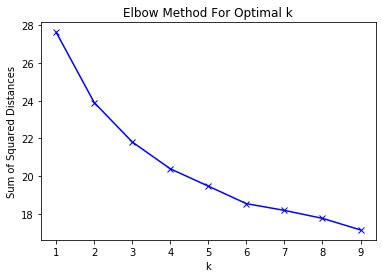

In [77]:
import sklearn
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(1, 10)
toronto_ln_grouped_clustering = toronto_ln_grouped.drop('Neighbourhood', 1)

for kvalues in K:
    #km = KMeans(n_clusters=kvalues, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(toronto_ln_grouped_clustering)
    km = KMeans(n_clusters=kvalues, init='k-means++', n_init=10, max_iter=300).fit(toronto_ln_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow point of the line chart is determined as the right K for clustering. Here K equals to 3.

<font size="3">**Run K-Means to cluster all the neighborhoods in Toronto and London into 3 clusters.**</font><br>

In [91]:
# set number of clusters to 3
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=None).fit(toronto_ln_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 3, 1, 2, 0, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 2, 3,
       1, 1, 1, 0, 1, 2, 2, 0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 0, 1, 0, 0, 2, 2, 2, 1, 1, 2, 2, 3, 1, 2, 1, 0, 1, 1, 1, 1,
       2, 1, 1, 1, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 3, 1, 2, 1, 0,
       1, 1, 1, 0, 1, 1, 2, 3, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 3, 2, 0,
       1, 1, 1, 3, 0, 1, 2, 1, 3, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 2, 1, 3, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 1,
       1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 0, 1, 1, 1, 0, 0, 2, 1, 2, 2, 0, 3,
       1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 2, 3])

Create a new dataframe that includes the cluster as well as the top 5 venues for each Neighbourhood in Toronto and London.

In [92]:
# add clustering labels
toronto_ln_venues_sorted = toronto_ln_venues_sorted.drop(['Cluster_Labels'], axis=1)
toronto_ln_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

toronto_ln_merged = df_toronto_london

# merge sorted venues with df_toronto_ln to add latitude/longitude for each Neighbourhood
toronto_ln_merged = toronto_ln_merged.join(toronto_ln_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

#Drop the rows that have no data.
toronto_ln_merged=toronto_ln_merged.dropna()
toronto_ln_merged.shape

print(toronto_ln_merged.shape)
toronto_ln_merged.head(10)

(275, 16)


,City,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,North York,Parkwoods,43.753259,-79.329656,3.0,Convenience Store,Park,Street Food,Flower Shop,Farmers Market,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market
1,Toronto,North York,Victoria Village,43.725882,-79.315572,0.0,Restaurant,Cafeteria,Intersection,Hockey Arena,Flower Shop,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market
2,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,2.0,Cafeteria,Restaurant,Park,Pub,Bakery,Breakfast Spot,Theater,Chocolate Shop,Health Food Store,Distribution Center
3,Toronto,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,2.0,Clothing Store,Furniture / Home Store,Accessories Store,Women's Store,Restaurant,Event Space,Boutique,Miscellaneous Shop,Cafeteria,Hospital
4,Toronto,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,1.0,Cafeteria,Restaurant,Bar,Hobby Shop,Diner,Discount Store,Distribution Center,Sandwich Place,College Cafeteria,College Auditorium
6,Toronto,Scarborough,Malvern / Rouge,43.806686,-79.194353,0.0,Restaurant,Hotel,Flower Shop,Farmers Market,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food Service
7,Toronto,North York,Don Mills,43.745906,-79.352188,0.0,Restaurant,Gym,Cafeteria,Sports,Bar,Sandwich Place,Shopping Mall,Supermarket,Clothing Store,Discount Store
8,Toronto,East York,Parkview Hill / Woodbine Gardens,43.706397,-79.309937,1.0,Restaurant,Gym,Gastropub,Pet Store,Pharmacy,Intersection,Bank,Field,Film Studio,Fish & Chips Shop
9,Toronto,Downtown Toronto,Garden District,43.657162,-79.378937,1.0,Restaurant,Cafeteria,Clothing Store,Bubble Tea Shop,Cosmetics Shop,Hotel,Lingerie Store,Bookstore,Gym,Tea Room
10,Toronto,North York,Glencairn,43.709577,-79.445073,0.0,Restaurant,Bakery,Pub,Flower Shop,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Hotel


Define a function to visualize the resulting clusters.

In [93]:
def displayClusters(city, country, dataframe):

    address = city + ',' + country

    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    cluster_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Cluster_Labels
    x = np.arange(kclusters)
    ys = [i+x+(i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    for lat, lon, neighbourhood, borough, cluster_labels in zip(dataframe['Latitude'], 
                                                                dataframe['Longitude'], 
                                                                dataframe['Neighbourhood'], 
                                                                dataframe['Borough'],
                                                                dataframe['Cluster_Labels']):
        cluster = int(cluster_labels)
        label = '{}, {},Cluster {}'.format(neighbourhood, borough, cluster)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(cluster_map)
    return cluster_map

## <br> 4. Results

<font size="3">**Examine and distinguish each cluster.**</font><br>

Let's check the total number of neighborhoods in each cluster.

In [94]:
for cluster_num in range(kclusters):
    num_of_nbh = toronto_ln_merged[toronto_ln_merged['Cluster_Labels'] == cluster_num].shape[0]
    print('The number of neighbourhoods in cluster {} is {}'.format(cluster_num+1, num_of_nbh))

The number of neighbourhoods in cluster 1 is 37
The number of neighbourhoods in cluster 2 is 170
The number of neighbourhoods in cluster 3 is 55
The number of neighbourhoods in cluster 4 is 13


<br><font size="4">**Cluster 1**</font>

In [95]:
cluster1 = toronto_ln_merged.loc[toronto_ln_merged['Cluster_Labels'] == 0]
print('There are {} neighborhoods in cluster 1'.format(cluster1.shape[0]))
cluster1

There are 37 neighborhoods in cluster 1


,City,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Toronto,North York,Victoria Village,43.725882,-79.315572,0.0,Restaurant,Cafeteria,Intersection,Hockey Arena,Flower Shop,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market
6,Toronto,Scarborough,Malvern / Rouge,43.806686,-79.194353,0.0,Restaurant,Hotel,Flower Shop,Farmers Market,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food Service
7,Toronto,North York,Don Mills,43.745906,-79.352188,0.0,Restaurant,Gym,Cafeteria,Sports,Bar,Sandwich Place,Shopping Mall,Supermarket,Clothing Store,Discount Store
10,Toronto,North York,Glencairn,43.709577,-79.445073,0.0,Restaurant,Bakery,Pub,Flower Shop,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Hotel
11,Toronto,Etobicoke,West Deane Park / Princess Gardens / Martin Gr...,43.650943,-79.554724,0.0,Restaurant,Hotel,Flower Shop,Farmers Market,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food Service
13,Toronto,North York,Don Mills,43.725900,-79.340923,0.0,Restaurant,Gym,Cafeteria,Sports,Bar,Sandwich Place,Shopping Mall,Supermarket,Clothing Store,Discount Store
22,Toronto,Scarborough,Woburn,43.770992,-79.216917,0.0,Cafeteria,Restaurant,Food Service,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food Stand
26,Toronto,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Restaurant,Gym,Bank,Fried Chicken Joint,Bakery,Gas Station,Fountain,Forest,Food Stand,Fabric Shop
27,Toronto,North York,Hillcrest Village,43.803762,-79.363452,0.0,Restaurant,Pool,Golf Course,Dog Run,Hotel,Fish Market,Field,Film Studio,Fish & Chips Shop,Flea Market
37,Toronto,West Toronto,Little Portugal / Trinity,43.647927,-79.419750,0.0,Restaurant,Bar,Cafeteria,Men's Store,Juice Bar,Park,Miscellaneous Shop,Cupcake Shop,Boutique,Theater


In [96]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster1[cluster1['City'] == 'Toronto'])

Toronto:


In [97]:
print('London:')
displayClusters('London', 'United Kingdom', cluster1[cluster1['City'] == 'London'])

London:


<br><font size="4">**Cluster 2**</font>

In [98]:
cluster2 = toronto_ln_merged.loc[toronto_ln_merged['Cluster_Labels'] == 1]
print('There are {} neighborhoods in cluster 2'.format(cluster2.shape[0]))
cluster2

There are 170 neighborhoods in cluster 2


,City,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Toronto,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,1.0,Cafeteria,Restaurant,Bar,Hobby Shop,Diner,Discount Store,Distribution Center,Sandwich Place,College Cafeteria,College Auditorium
8,Toronto,East York,Parkview Hill / Woodbine Gardens,43.706397,-79.309937,1.0,Restaurant,Gym,Gastropub,Pet Store,Pharmacy,Intersection,Bank,Field,Film Studio,Fish & Chips Shop
9,Toronto,Downtown Toronto,Garden District,43.657162,-79.378937,1.0,Restaurant,Cafeteria,Clothing Store,Bubble Tea Shop,Cosmetics Shop,Hotel,Lingerie Store,Bookstore,Gym,Tea Room
15,Toronto,Downtown Toronto,St. James Town,43.651494,-79.375418,1.0,Restaurant,Cafeteria,Bar,Gastropub,Gym,Lingerie Store,Clothing Store,Cosmetics Shop,Creperie,Art Museum
18,Toronto,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711,1.0,Bank,Rental Car Location,Electronics Store,Medical Center,Breakfast Spot,Restaurant,Intersection,Fried Chicken Joint,Fountain,Forest
20,Toronto,Downtown Toronto,Berczy Park,43.644771,-79.373306,1.0,Restaurant,Cafeteria,Bar,Cheese Shop,Bakery,Art Museum,Hotel,Nightclub,Gourmet Shop,Tailor Shop
24,Toronto,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1.0,Restaurant,Cafeteria,Sandwich Place,Dessert Shop,Bubble Tea Shop,Salad Place,Burger Joint,Bar,Ice Cream Shop,Poke Place
28,Toronto,North York,Bathurst Manor / Wilson Heights / Downsview North,43.754328,-79.442259,1.0,Restaurant,Cafeteria,Bank,Video Store,Sandwich Place,Gas Station,Bridal Shop,Diner,Fried Chicken Joint,Deli / Bodega
29,Toronto,East York,Thorncliffe Park,43.705369,-79.349372,1.0,Restaurant,Bank,Sandwich Place,Discount Store,Park,Supermarket,Gas Station,Burger Joint,Grocery Store,Warehouse Store
30,Toronto,Downtown Toronto,Richmond / Adelaide / King,43.650571,-79.384568,1.0,Restaurant,Cafeteria,Gym,Deli / Bodega,Clothing Store,Hotel,Bookstore,Bakery,Art Museum,Cosmetics Shop


In [99]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster2[cluster2['City'] == 'Toronto'])

Toronto:


In [100]:
print('London:')
displayClusters('London', 'United Kingdom', cluster2[cluster2['City'] == 'London'])

London:


<br><font size="4">**Cluster 3**</font>

In [101]:
cluster3 = toronto_ln_merged.loc[toronto_ln_merged['Cluster_Labels'] == 2]
print('There are {} neighborhoods in cluster 3'.format(cluster3.shape[0]))
cluster3

There are 55 neighborhoods in cluster 3


,City,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,2.0,Cafeteria,Restaurant,Park,Pub,Bakery,Breakfast Spot,Theater,Chocolate Shop,Health Food Store,Distribution Center
3,Toronto,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,2.0,Clothing Store,Furniture / Home Store,Accessories Store,Women's Store,Restaurant,Event Space,Boutique,Miscellaneous Shop,Cafeteria,Hospital
12,Toronto,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,2.0,Moving Target,Golf Course,Bar,Hotel,Flea Market,Field,Film Studio,Fish & Chips Shop,Fish Market,Flower Shop
14,Toronto,East York,Woodbine Heights,43.695344,-79.318389,2.0,Curling Ice,Cosmetics Shop,Spa,Skating Rink,Bar,Park,Dance Studio,Pharmacy,Video Store,Food Service
17,Toronto,Etobicoke,Eringate / Bloordale Gardens / Old Burnhamthor...,43.643515,-79.577201,2.0,Cafeteria,Liquor,Convenience Store,Cosmetics Shop,Bar,Park,Restaurant,Food Stand,Forest,Fountain
19,Toronto,East Toronto,The Beaches,43.676357,-79.293031,2.0,Cafeteria,Pub,Neighborhood,Trail,Health Food Store,Dessert Shop,Diner,Frozen Yogurt Shop,Fried Chicken Joint,Fountain
23,Toronto,East York,Leaside,43.709060,-79.363452,2.0,Sports,Cafeteria,Restaurant,Burger Joint,Furniture / Home Store,Bank,Electronics Store,Sandwich Place,Brewery,Grocery Store
25,Toronto,Downtown Toronto,Christie,43.669542,-79.422564,2.0,Grocery Store,Cafeteria,Restaurant,Park,Gym,Baby Store,Diner,Nightclub,Candy Store,Frozen Yogurt Shop
31,Toronto,West Toronto,Dufferin / Dovercourt Village,43.669005,-79.442259,2.0,Bakery,Pharmacy,Gym,Bank,Grocery Store,Gas Station,Park,Pool,Music Venue,Cafeteria
32,Toronto,Scarborough,Scarborough Village,43.744734,-79.239476,2.0,Playground,Business Service,Food Service,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Hotel


In [102]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster3[cluster3['City'] == 'Toronto'])

Toronto:


In [103]:
print('London:')
displayClusters('London', 'United Kingdom', cluster3[cluster3['City'] == 'London'])

London:


<br><font size="4">**Cluster 4**</font>

In [105]:
cluster4 = toronto_ln_merged.loc[toronto_ln_merged['Cluster_Labels'] == 3]
print('There are {} neighborhoods in cluster 4'.format(cluster3.shape[0]))
cluster4

There are 55 neighborhoods in cluster 4


,City,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,North York,Parkwoods,43.753259,-79.329656,3.0,Convenience Store,Park,Street Food,Flower Shop,Farmers Market,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market
16,Toronto,York,Humewood-Cedarvale,43.693781,-79.428191,3.0,Trail,Field,Park,Hockey Arena,Flower Shop,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Hotel
21,Toronto,York,Caledonia-Fairbanks,43.689026,-79.453512,3.0,Women's Store,Pool,Park,Hotel,Fish Market,Farmers Market,Field,Film Studio,Fish & Chips Shop,Flea Market
35,Toronto,East York,East Toronto,43.685347,-79.338106,3.0,Convenience Store,Park,Food Service,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Hotel
49,Toronto,North York,North Park / Maple Leaf Park / Upwood Park,43.713756,-79.490074,3.0,Bakery,Park,Construction & Landscaping,Flower Shop,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Hotel
61,Toronto,Central Toronto,Lawrence Park,43.728020,-79.388790,3.0,Swim School,Bus Line,Park,Hotel,Flower Shop,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market
64,Toronto,York,Weston,43.706876,-79.518188,3.0,Convenience Store,Park,Food Service,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Hotel
66,Toronto,North York,York Mills West,43.752758,-79.400049,3.0,Park,Convenience Store,Bank,Bar,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
85,Toronto,Scarborough,Milliken / Agincourt North / Steeles East / L'...,43.815252,-79.284577,3.0,Park,Playground,Hotel,Fabric Shop,Fried Chicken Joint,Fountain,Forest,Food Stand,Food Service,Flower Shop
91,Toronto,Downtown Toronto,Rosedale,43.679563,-79.377529,3.0,Park,Trail,Playground,Fountain,Forest,Fried Chicken Joint,Food Stand,Food Service,Fruit & Vegetable Store,Flower Shop


In [109]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster4[cluster4['City'] == 'Toronto'])

Toronto:


In [110]:
print('London:')
displayClusters('London', 'United Kingdom', cluster4[cluster4['City'] == 'London'])

London:


## <br> 5. Discussion
From the results, we can conclude that for those who prefer to settle down in a residential area where surrounded by parks, grocery stores, pharmacy and restaurants, clusters 1 and 3 would be the best choice. While for those who prefer to live in a more crowded area where have access to a variety of venues, cluster 2 would be the best choice.